In [ ]:
!pip install colorama

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from colorama import Fore, Style
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Directory Paths and Load Data

In [ ]:
# Root_dir = "/content/drive/MyDrive/dataset-directory/New Plant Diseases (Augmented)/New Plant Diseases Dataset(AuDatasetgmented)"

Root_dir = "/content/drive/MyDrive/dataset-directory/new_dataset"


# Define the subdirectories for training, validation, and test sets
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/content/drive/MyDrive/dataset-directory/test"

# List the classes in the training directory
Diseases_classes = os.listdir(train_dir)

In [ ]:
print(Fore.GREEN +str(Diseases_classes))
print("\nTotal number of classes are: ", len(Diseases_classes))

['Apple___Black_rot', 'Cherry_(including_sour)___Powdery_mildew_small', 'Corn_(maize)___Common_rust_small']

Total number of classes are:  3


In [ ]:
    image_path = os.listdir(test_dir )
    print(Fore.GREEN)
    print("The Number of Images in  test directory is: ", len(image_path), end= " ")


The Number of Images in Corn_(maize)___Common_rust_small: 33 


The Number of Images in Apple___Black_rot: 1533 
The Number of Images in Cherry_(including_sour)___Powdery_mildew_small: 869 
The Number of Images in Corn_(maize)___Common_rust_small: 837 
Total Number of Images in Directory:  3239


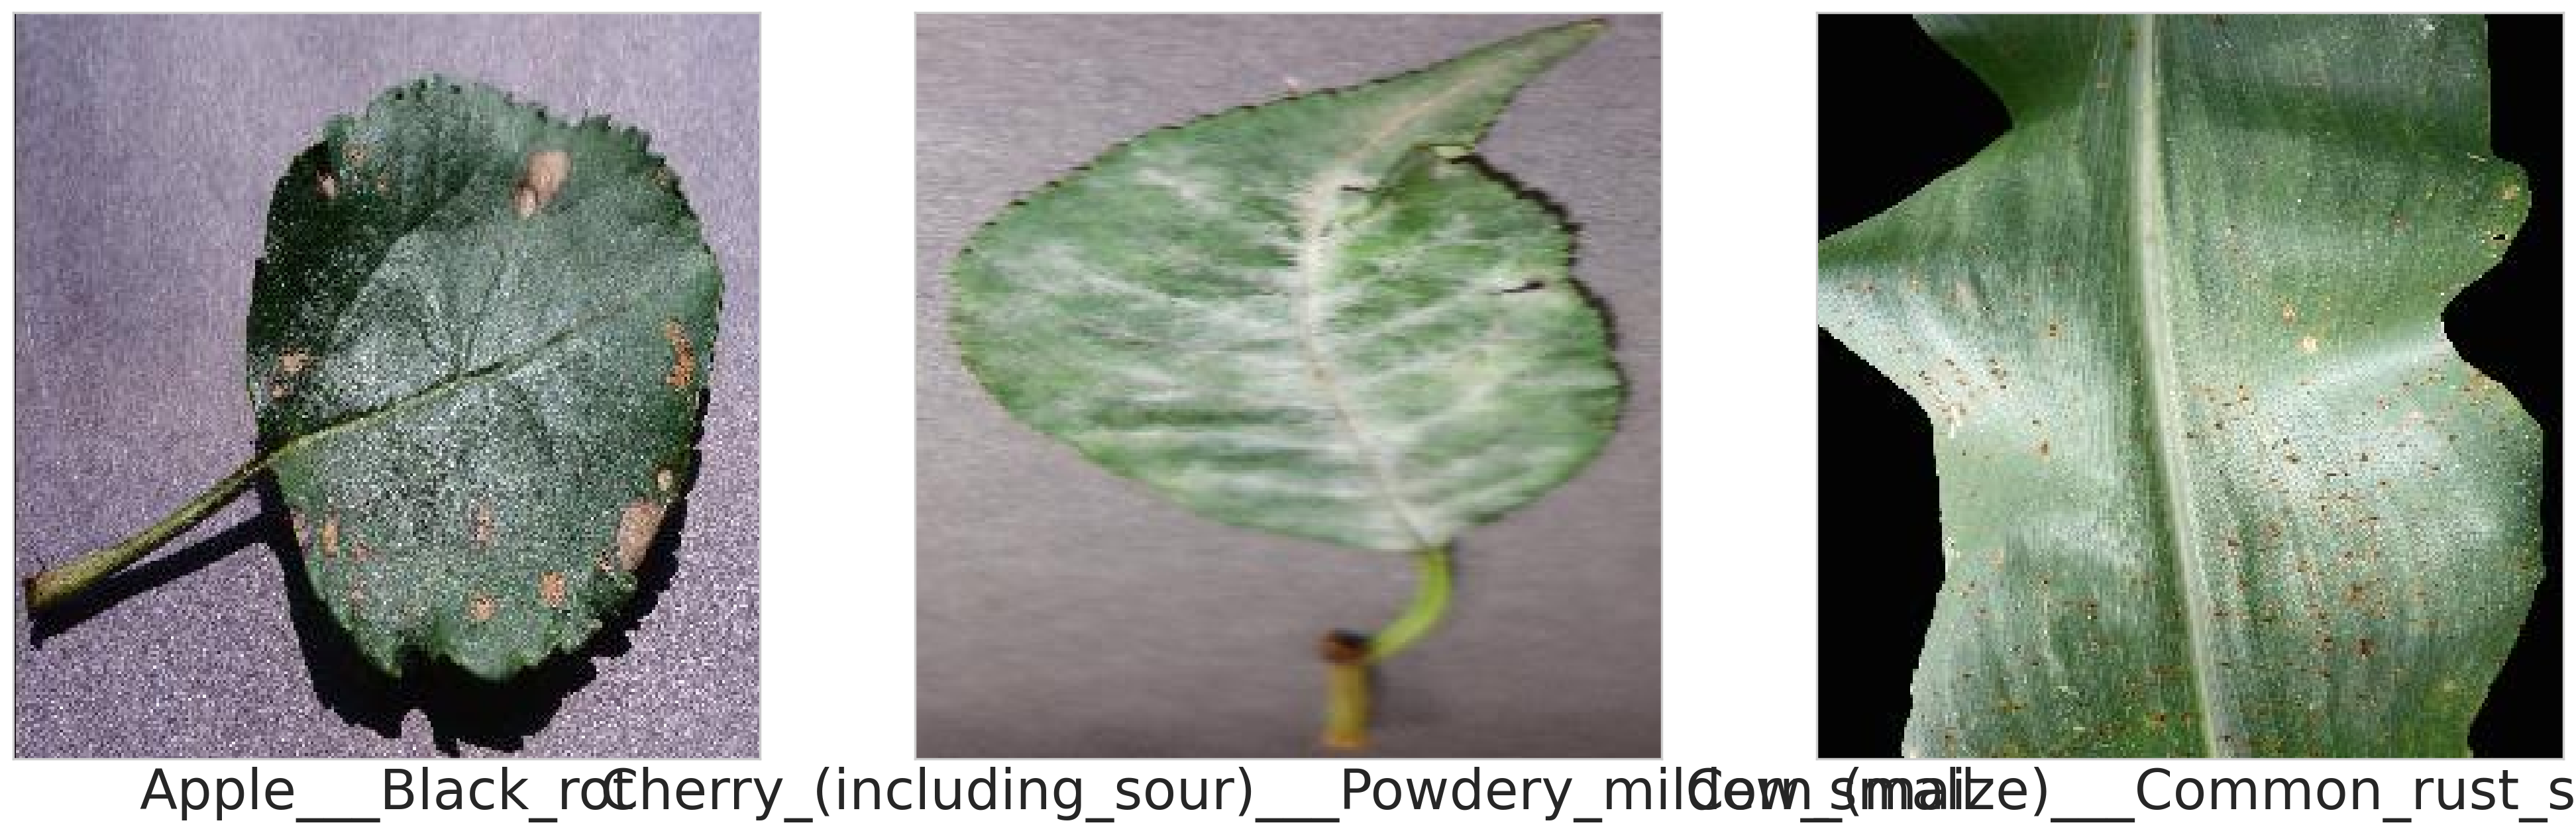

In [ ]:

plt.figure(figsize=(60,60), dpi=200)
cnt = 0
plant_names = []
tot_images = 0

for i in Diseases_classes:
    cnt += 1
    plant_names.append(i)
    plt.subplot(7,7,cnt)

    image_path = os.listdir(train_dir + "/" + i)
    print(Fore.GREEN)
    print("The Number of Images in " + i + ":", len(image_path), end= " ")
    tot_images += len(image_path)

    img_show = plt.imread(train_dir + "/" + i + "/" + image_path[0])

    plt.imshow(img_show)
    plt.xlabel(i, fontsize=30)
    plt.xticks([])
    plt.yticks([])

print("\nTotal Number of Images in Directory: ", tot_images)



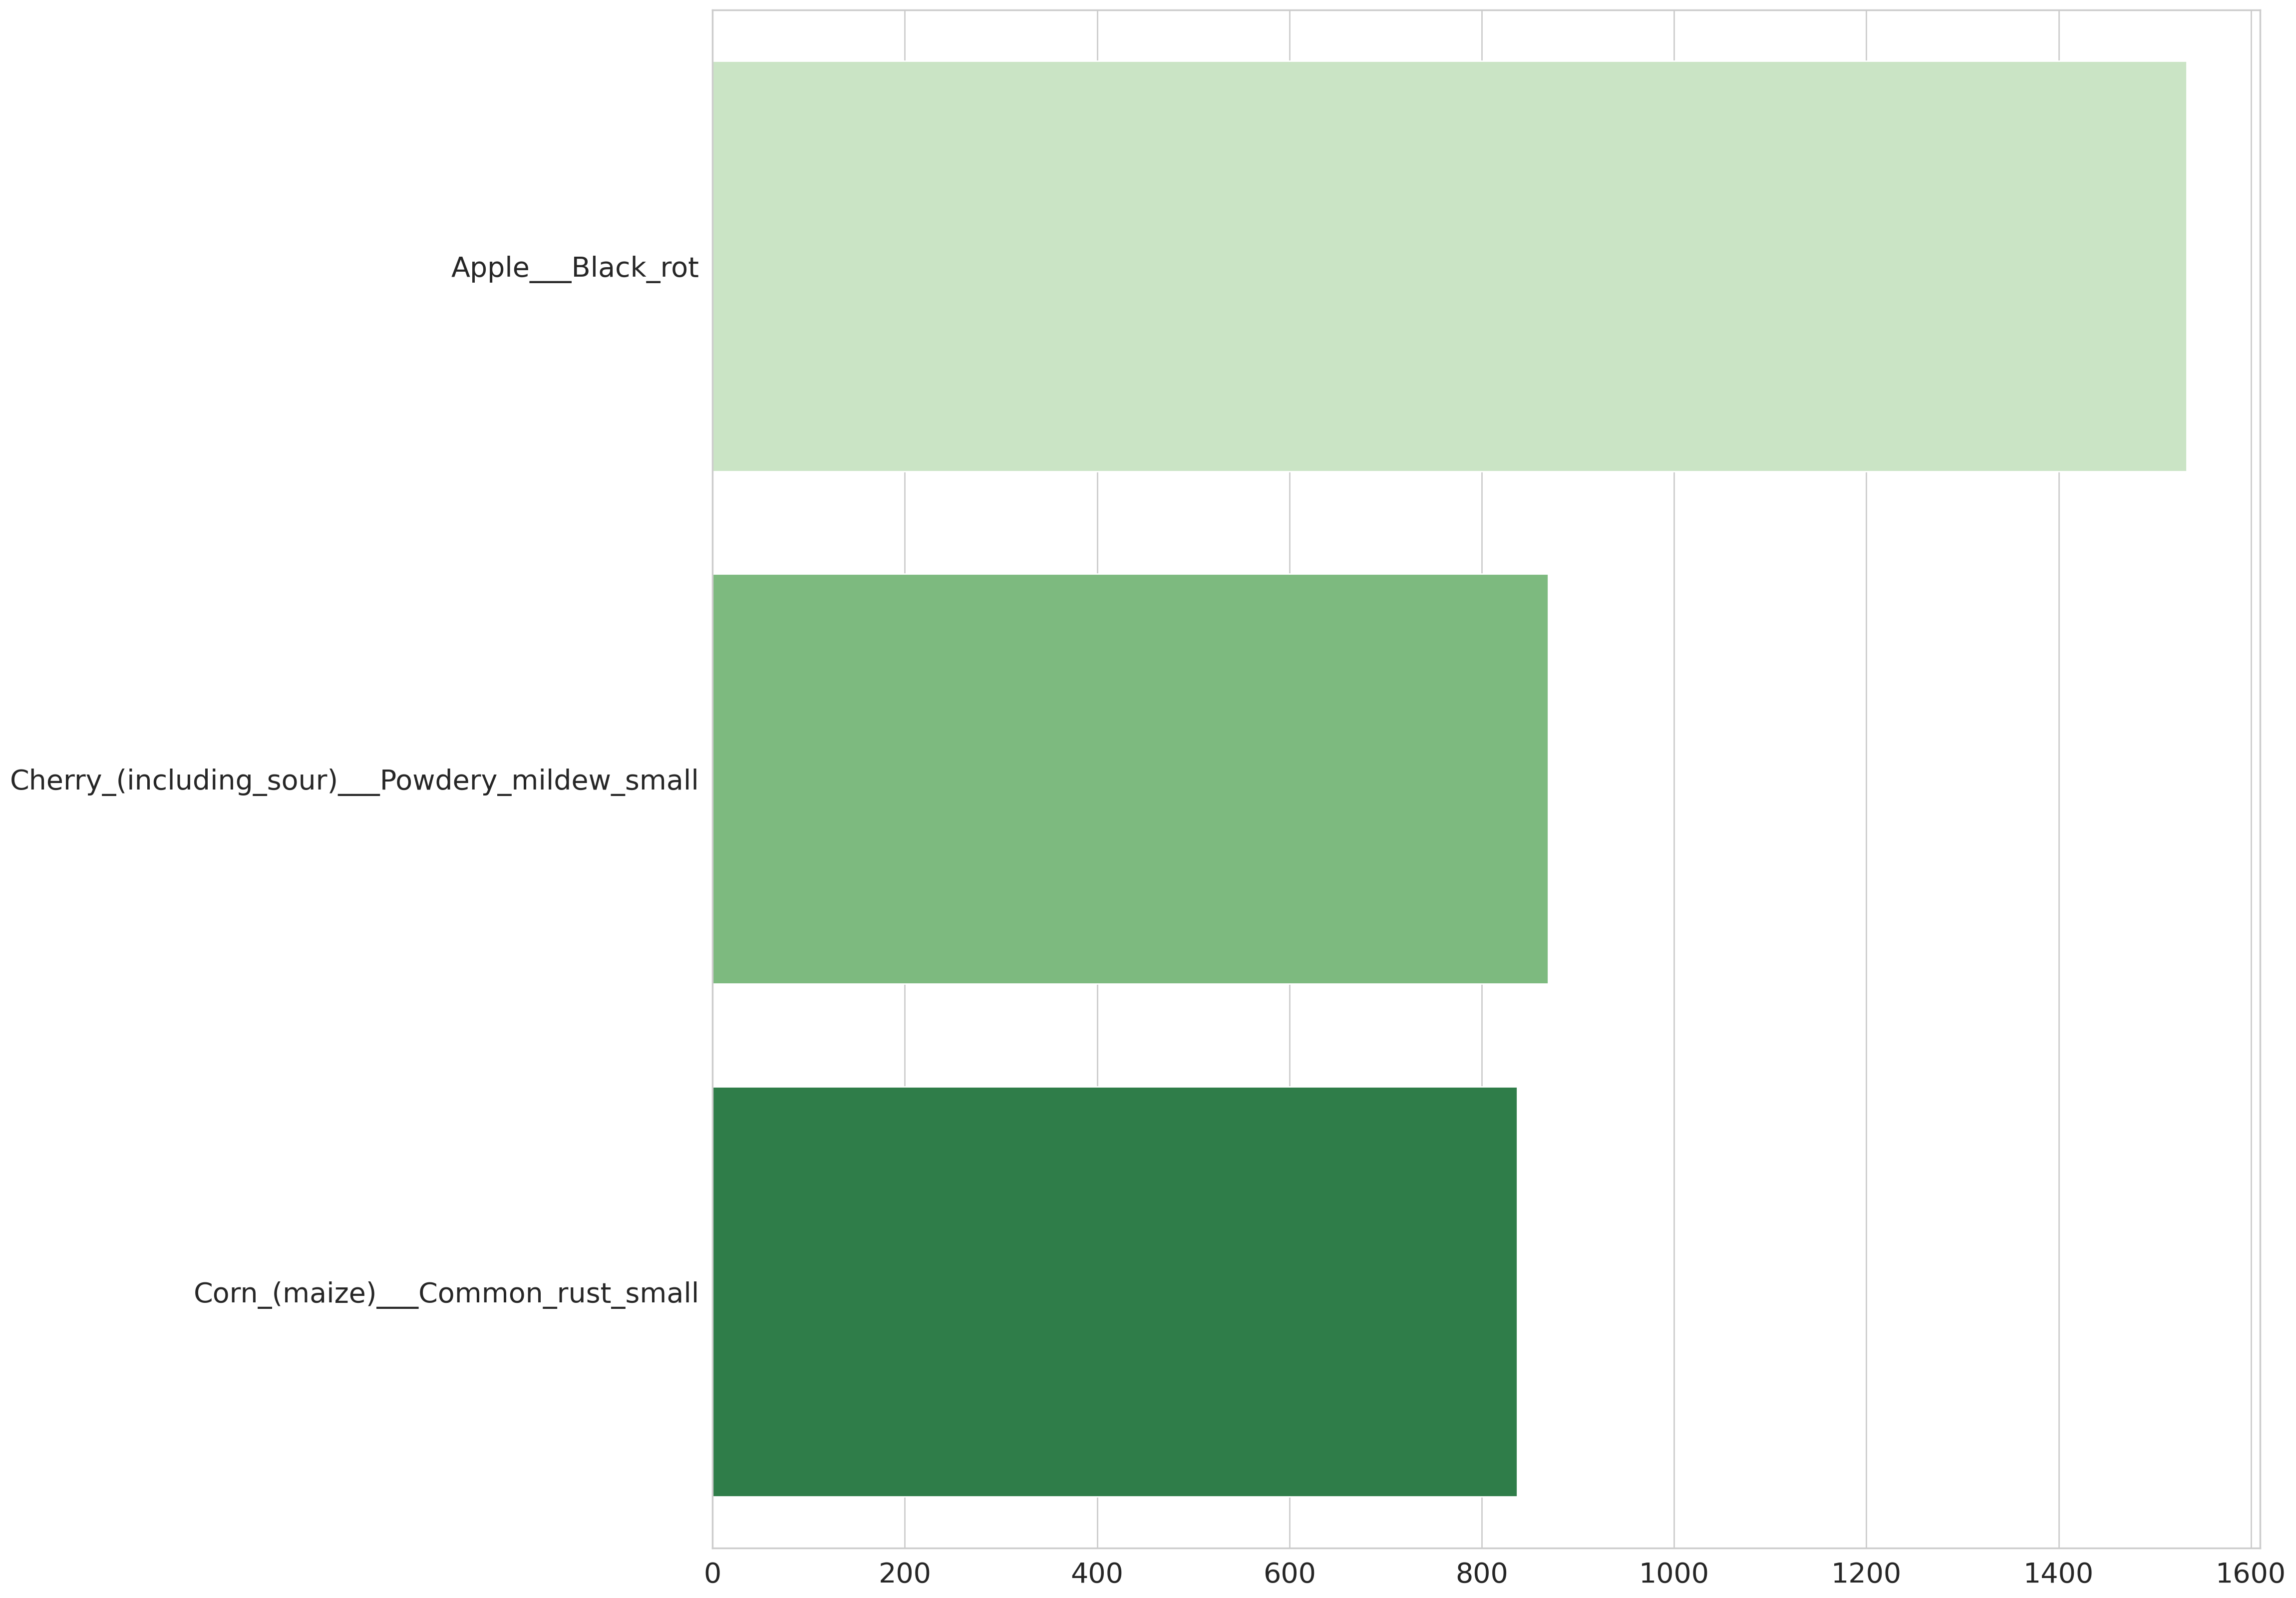

In [ ]:
plant_names = []
Len = []
for i in Diseases_classes:
    plant_names.append(i)
    imgs_path = os.listdir(train_dir + "/" + i)
    Len.append(len(imgs_path))

Len.sort(reverse=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,20), dpi=200)
ax = sns.barplot(x=Len, y=plant_names, palette="Greens")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Set Up Data Generators

In [ ]:
# Image data generators
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
   subset='validation'
)

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


Found 2593 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 0 images belonging to 0 classes.


In [ ]:
x_train, y_train = next(train_generator)
print(f"Shape of inputs (train): {x_train.shape}")
print(f"Shape of labels (train): {y_train.shape}")

x_valid, y_valid = next(valid_generator)
print(f"Shape of inputs (valid): {x_valid.shape}")
print(f"Shape of labels (valid): {y_valid.shape}")


Shape of inputs (train): (8, 224, 224, 3)
Shape of labels (train): (8, 3)
Shape of inputs (valid): (8, 224, 224, 3)
Shape of labels (valid): (8, 3)


ValueError: not enough values to unpack (expected 2, got 0)

Define and Compile the Model


In [ ]:
def create_model(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

model = create_model(len(Diseases_classes))
#model = create_model(num_classes=4)
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


ورژن 2

In [ ]:
from tensorflow.keras.layers import Dropout

def create_model(num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)


    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
#    x = ReLU()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
#    x = ReLU()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)  # Dropout با مقدار بیشتر بعد از لایه‌های عمیق‌تر

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    # Fifth Conv Block (back to 256 filters)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Sixth Conv Block (back to 128 filters)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Final Conv Block (back to 64 filters)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model


model = create_model(len(Diseases_classes))
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train the model

In [ ]:
# Define learning rate scheduler
class LRLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        #lr = K.get_value(self.model.optimizer.lr)
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f'\nLearning rate at end of epoch {epoch}: {lr}')

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Train the model
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=valid_generator,
    callbacks=[LRLogger(), lr_scheduler],
    verbose=2
)


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
val_acc = []
val_loss = []
train_loss = []

# استخراج داده‌ها از history.history
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_loss = history.history['loss']

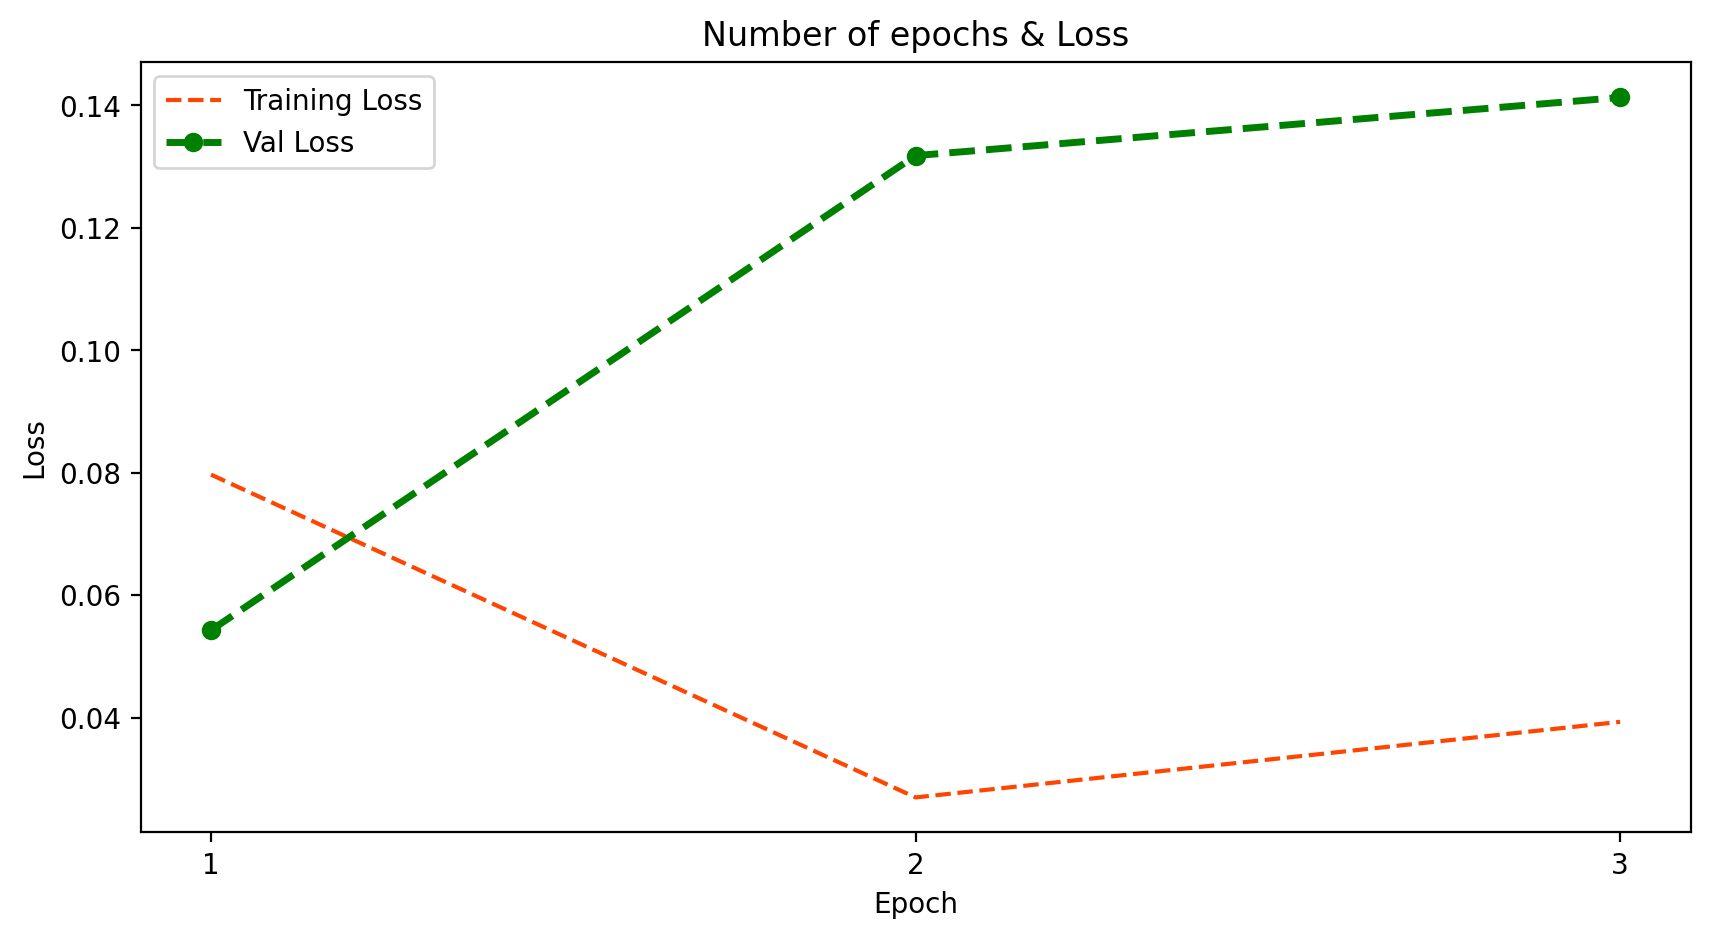

In [ ]:
epoch_count = range(1, len(val_acc) + 1)

# رسم نمودار خطا (Loss)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color='orangered', label='Training Loss')
plt.plot(epoch_count, val_loss, '--bo', color='green', linewidth=2.5, label='Val Loss')
plt.legend()
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(val_acc) + 1, 1))
plt.show()


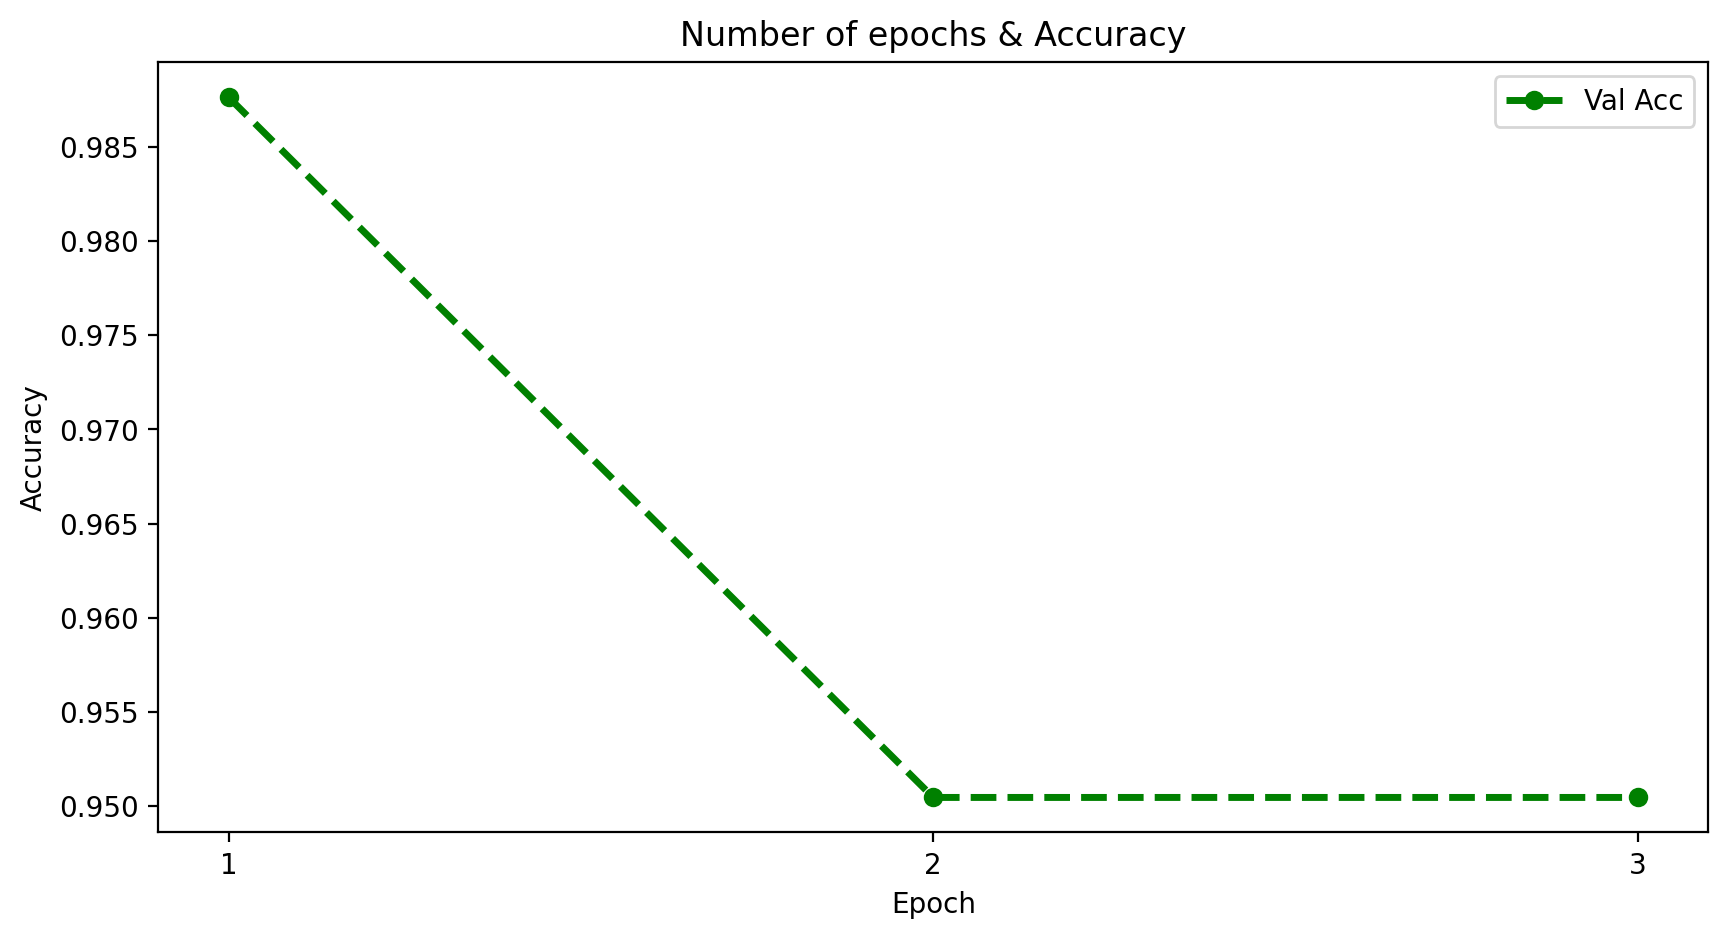

In [ ]:
# رسم نمودار دقت (Accuracy)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo', color='green', linewidth=2.5, label='Val Acc')
plt.legend()
plt.title('Number of epochs & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, len(val_acc) + 1, 1))
plt.show()

Predict on test set

In [ ]:

# List all image filenames from subdirectories
image_paths = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg','JPG')):  # Add other extensions if necessary
            image_paths.append(os.path.join(root, file))

# Print total number of test images
print(f"Found {len(image_paths)} images in the test set.")

# Function to load and preprocess image for model prediction
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Iterate over the test images and predict
for image_path in image_paths:
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])

    # Map the predicted index to class label
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_idx]

    # Extract the actual filename from the path
    actual_filename = os.path.basename(image_path)

    # Print the result
    print(f"Label: {actual_filename}, Predicted: {predicted_class}")


[]
